In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.applications.efficientnet import EfficientNetB3
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt



C:\Users\saina\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load and preprocess the training data
train_df = pd.read_csv('C:\\Users\\saina\\OneDrive\\Desktop\\analytics vidhya\\train\\train.csv')
train_images = []
train_labels = []

for index, row in train_df.iterrows():
    image_path = os.path.join('C:\\Users\\saina\\OneDrive\\Desktop\\analytics vidhya\\train\\images', row['filename'])
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values
    train_images.append(image)
    train_labels.append(row['label'])

train_images = np.array(train_images)
train_labels = np.array(train_labels)



In [3]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels_encoded, test_size=0.3, random_state=42
)

In [4]:
unique_values = np.unique(y_train, axis=0)
print('Unique values in y_train:',unique_values)


Unique values in y_train: [0 1 2 3 4 5]


In [5]:
# Model creation function
def create_model(image_input_shape):
    decay = 0.000001
    input_image = tf.keras.layers.Input(shape=image_input_shape)

    # Use EfficientNetB3 as the base model
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=input_image)
    x = base_model.output

    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    output_layer = Dense(6, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

    return model



In [6]:
# Define image input shape and number of classes
image_input_shape = (224, 224, 3)  # Adjust this based on your image dimensions





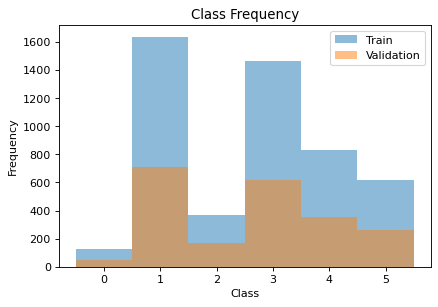

In [7]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Assuming y_train and y_val are label-encoded arrays
figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')

# Plot class frequencies for y_train
plt.hist(y_train, bins=np.arange(0, 7) - 0.5, alpha=0.5, label='Train')

# Plot class frequencies for y_val
plt.hist(y_val, bins=np.arange(0, 7) - 0.5, alpha=0.5, label='Validation')

plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 6))  # Assuming you have 6 classes
plt.legend(loc='best')

plt.show()


# The Dataset is Imbalanced
# steps taken to train my model to avoid Overfitting 

# 1) Re-weighting

In [8]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

# Convert class weights to a dictionary
class_weights = dict(zip(np.unique(train_labels), class_weights))

print(class_weights)

{1: 7.017543859649122, 2: 0.5108556832694764, 3: 2.247191011235955, 4: 0.5772005772005772, 5: 1.0126582278481013, 6: 1.3605442176870748}


### 2) Data Augmentation & Random Over Sampling

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
# Define your data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [11]:
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator
from sklearn.utils import class_weight

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()



In [12]:
# Create data generators
balanced_gen = BalancedDataGenerator(X_train, y_train, datagen, batch_size=32)
balanced_gen_val = BalancedDataGenerator(X_val, y_val, datagen, batch_size=32)
steps_per_epoch = balanced_gen.steps_per_epoch


### 3) Learning Rate Scheduler

In [13]:


class LossLearningRateScheduler(tf.keras.callbacks.History):
    """
    A learning rate scheduler that relies on changes in loss function
    value to dictate whether learning rate is decayed or not.
    LossLearningRateScheduler has the following properties:
    base_lr: the starting learning rate
    lookback_epochs: the number of epochs in the past to compare with the loss function at the current epoch to determine if progress is being made.
    decay_threshold / decay_multiple: if loss function has not improved by a factor of decay_threshold * lookback_epochs, then decay_multiple will be applied to the learning rate.
    spike_epochs: list of the epoch numbers where you want to spike the learning rate.
    spike_multiple: the multiple applied to the current learning rate for a spike.
    """

    def __init__(self, base_lr, lookback_epochs, spike_epochs = None, spike_multiple = 10, decay_threshold = 0.002, decay_multiple = 0.7, loss_type = 'val_loss'):

        super(LossLearningRateScheduler, self).__init__()

        self.base_lr = base_lr
        self.lookback_epochs = lookback_epochs
        self.spike_epochs = spike_epochs
        self.spike_multiple = spike_multiple
        self.decay_threshold = decay_threshold
        self.decay_multiple = decay_multiple
        self.loss_type = loss_type


    def on_epoch_begin(self, epoch, logs=None):

        if len(self.epoch) > self.lookback_epochs:

            current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)

            target_loss = self.history[self.loss_type] 

            loss_diff =  target_loss[-int(self.lookback_epochs)] - target_loss[-1]

            if loss_diff <= np.abs(target_loss[-1]) * (self.decay_threshold * self.lookback_epochs):

                print(' '.join(('Changing learning rate from', str(current_lr), 'to', str(current_lr * self.decay_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.decay_multiple)
                current_lr = current_lr * self.decay_multiple

            else:

                print(' '.join(('Learning rate:', str(current_lr))))

            if self.spike_epochs is not None and len(self.epoch) in self.spike_epochs:
                print(' '.join(('Spiking learning rate from', str(current_lr), 'to', str(current_lr * self.spike_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.spike_multiple)

        else:

            print(' '.join(('Setting learning rate to', str(self.base_lr))))
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)


        return tf.keras.backend.get_value(self.model.optimizer.lr)



In [14]:
callback_lr = LossLearningRateScheduler(base_lr=0.001, lookback_epochs=3)

# 4) Focal Loss

In [15]:
import focal_loss
from focal_loss import SparseCategoricalFocalLoss
# model.compile(loss=SparseCategoricalFocalLoss(gamma=2) ,optimizer=tfa.optimizers.LazyAdam(0.001), metrics=['accuracy'])

#  Create Model, Training and Validating Phase

In [16]:
import tensorflow_addons as tfa


C:\Users\saina\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\saina\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure yo

In [17]:
model = create_model(image_input_shape)
model.compile(loss='sparse_categorical_crossentropy' ,optimizer=tfa.optimizers.LazyAdam(0.001), metrics=['accuracy'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]'] 

In [18]:
# Modify the dictionary keys to start from 0
class_weights_modified = {key - 1: value for key, value in class_weights.items()}
class_weights_modified


{0: 7.017543859649122,
 1: 0.5108556832694764,
 2: 2.247191011235955,
 3: 0.5772005772005772,
 4: 1.0126582278481013,
 5: 1.3605442176870748}

In [19]:
filepath = 'efficientnet1_best_weights.hdf5'
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

stop = EarlyStopping(monitor='val_accuracy', patience =5,
                      verbose=0, mode='auto', baseline=None, 
                      restore_best_weights=False)

callbacks = [checkpoint,stop,callback_lr]
          
# history = model.fit(X_train, y_train, class_weight=class_weights,validation_data=(X_val, y_val),epochs=30,shuffle=True,
#           batch_size=128,callbacks=callbacks)
history = model.fit_generator(balanced_gen, steps_per_epoch, class_weight=class_weights_modified,validation_data=balanced_gen_val,epochs=30,shuffle=True,
          callbacks=callbacks)


C:\Users\saina\AppData\Local\Temp\ipykernel_4808\970580634.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(balanced_gen, steps_per_epoch, class_weight=class_weights_modified,validation_data=balanced_gen_val,epochs=30,shuffle=True,


Setting learning rate to 0.001
Epoch 1/30


306/306 [==============================] - ETA: 0s - loss: 2.0883 - accuracy: 0.5534
Epoch 1: val_accuracy improved from -inf to 0.21226, saving model to efficientnet1_best_weights.hdf5


C:\Users\saina\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


306/306 [==============================] - 1800s 6s/step - loss: 2.0883 - accuracy: 0.5534 - val_loss: 1.8986 - val_accuracy: 0.2123
Setting learning rate to 0.001
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.6194 - accuracy: 0.7105
Epoch 2: val_accuracy improved from 0.21226 to 0.29723, saving model to efficientnet1_best_weights.hdf5
306/306 [==============================] - 1698s 6s/step - loss: 0.6194 - accuracy: 0.7105 - val_loss: 3.4265 - val_accuracy: 0.2972
Setting learning rate to 0.001
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.5169 - accuracy: 0.7628
Epoch 3: val_accuracy did not improve from 0.29723
306/306 [==============================] - 1669s 5s/step - loss: 0.5169 - accuracy: 0.7628 - val_loss: 3.0460 - val_accuracy: 0.1851
Setting learning rate to 0.001
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 0.4384 - accuracy: 0.8096
Epoch 4: val_accuracy improved from 0.29723 to 0.54151, saving mo

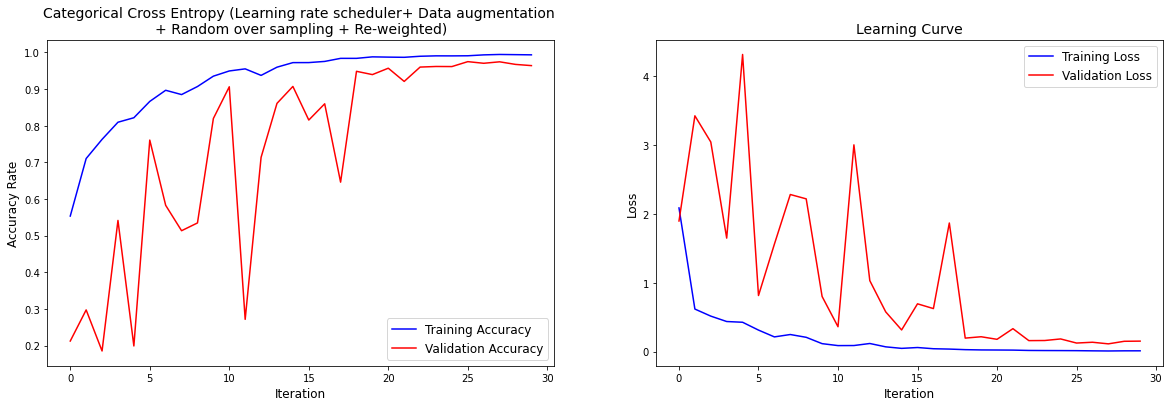

In [21]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

ax1.plot(history.history['accuracy'],'b', history.history['val_accuracy'], 'r')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title('Categorical Cross Entropy (Learning rate scheduler+ Data augmentation \n+ Random over sampling + Re-weighted)',fontsize=14)

ax1.legend(['Training Accuracy','Validation Accuracy'],fontsize=12,loc='best')

ax2.plot(history.history['loss'], 'b',history.history['val_loss'],'r')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve',fontsize=14)
ax2.legend(['Training Loss','Validation Loss'],fontsize=12,loc='best')

# plt.savefig('crosse_results.png')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('efficientnet1_best_weights.hdf5')


In [22]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt


# Make predictions on the validation set
y_val_pred_ohe = model.predict(X_val)
y_val_pred_labels = np.argmax(y_val_pred_ohe, axis=1)
y_val_true_labels = y_val  # Assuming y_val is label-encoded



68/68 [==============================] - 80s 1s/step


In [23]:
# Generate and print confusion matrix and classification report for validation set
confusion_matrix_val = confusion_matrix(y_true=y_val_true_labels, y_pred=y_val_pred_labels)
print("Confusion Matrix for Validation Set:")
print(confusion_matrix_val)



Confusion Matrix for Validation Set:
[[ 47   0   0   0   0   0]
 [  0 667   1  38   1   5]
 [  0   0 166   1   0   0]
 [  0  22   1 587   0   6]
 [  0   0   0   3 353   0]
 [  0  10   0   5   0 247]]


In [24]:
print("\nClassification Report for Validation Set:")
print(classification_report(y_val_true_labels, y_val_pred_labels))




Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       0.95      0.94      0.95       712
           2       0.99      0.99      0.99       167
           3       0.93      0.95      0.94       616
           4       1.00      0.99      0.99       356
           5       0.96      0.94      0.95       262

    accuracy                           0.96      2160
   macro avg       0.97      0.97      0.97      2160
weighted avg       0.96      0.96      0.96      2160



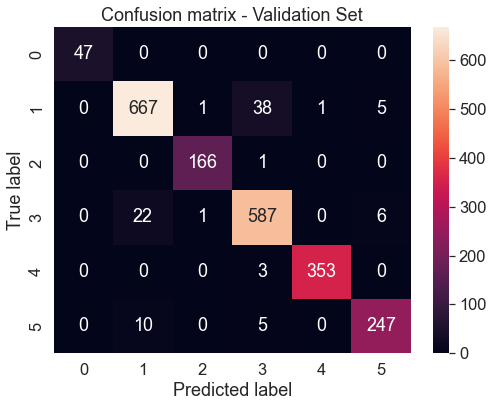

In [25]:
# Generate and plot confusion matrix for validation set
LABELS = np.unique(y_val_true_labels).astype('str')
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.heatmap(confusion_matrix_val, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix - Validation Set")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# The Performmance was very Good with val_accuracy as 96% , Lets do Testing 

# testing

In [26]:


# Load the test data
test_df = pd.read_csv('C:\\Users\\saina\\OneDrive\\Desktop\\analytics vidhya\\test\\test.csv')
test_images = []

# Assuming your test images are in a folder named 'images'
test_images_folder = 'C:\\Users\\saina\\OneDrive\\Desktop\\analytics vidhya\\test\\images'

# Load and preprocess test images
for index, row in test_df.iterrows():
    image_path = os.path.join(test_images_folder, row['filename'])
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values
    test_images.append(image)

test_images = np.array(test_images)



In [27]:

# Make predictions on the test set
predictions = model.predict(test_images)



150/150 [==============================] - 169s 1s/step


In [28]:
# Convert integer predictions directly for submission
predicted_labels = np.argmax(predictions, axis=1) + 1  # Adding 1 to convert back to 1-based indexing



In [29]:
# Create a DataFrame for submission
submission_df = pd.DataFrame({'image_id': test_df['image_id'], 'label': predicted_labels})

# Save the submission file
submission_df.to_csv('submissionfinal.csv', index=False)


# This task was given Analytics Vidya in a Competition  

# After the submission model performed with 80.5% Test accuracy 

# Got Placed in 10th position , Placed 1st positon model got Performed at 83.9 % Accuracy 